In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [2]:
# Wczytanie zbioru danych oraz nazwanie kolumn zgodnie z opisem
wines = pd.read_table("wine.data",sep=',',names=["Class","Alcochol","Malic acid","Ash","Alcalinity of ash","Magnesium","Total phenols","Flavaniods","Nonflavanoid phenols","Proanthocyanins"
             ,"Color intensity","Hue","OD280/OD315 of diluted wines","Proline"])
wines.head()

,Class,Alcochol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavaniods,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
# Zbiór treningowy i testowy
X = wines.drop("Class",axis=1)
y = wines["Class"]

In [4]:
# Stworzenie pełnego drzewa decyzyjnego oraz przetrenowanie go na zbiorze treningowym (powtórne podstawienie)
dtree = DecisionTreeClassifier()
dtree.fit(X,y)
predictions = dtree.predict(X)

In [5]:
# Macierze pomyłek oraz skuteczność klasyfikatora przez powtórne podstawienie
print(confusion_matrix(y,predictions))
print("Accuracy: ",accuracy_score(y, predictions))

[[59  0  0]
 [ 0 71  0]
 [ 0  0 48]]
Accuracy:  1.0


In [6]:
# Macierze pomyłek oraz skuteczność klasyfikatora przez kroswalidacje (k=10)
predictions = cross_val_predict(dtree, X, y, cv=10)
best_acc_full = accuracy_score(y, predictions)
print(confusion_matrix(y,predictions))
print("Accuracy: ",accuracy_score(y, predictions))

[[55  4  0]
 [ 6 61  4]
 [ 4  4 40]]
Accuracy:  0.8764044943820225


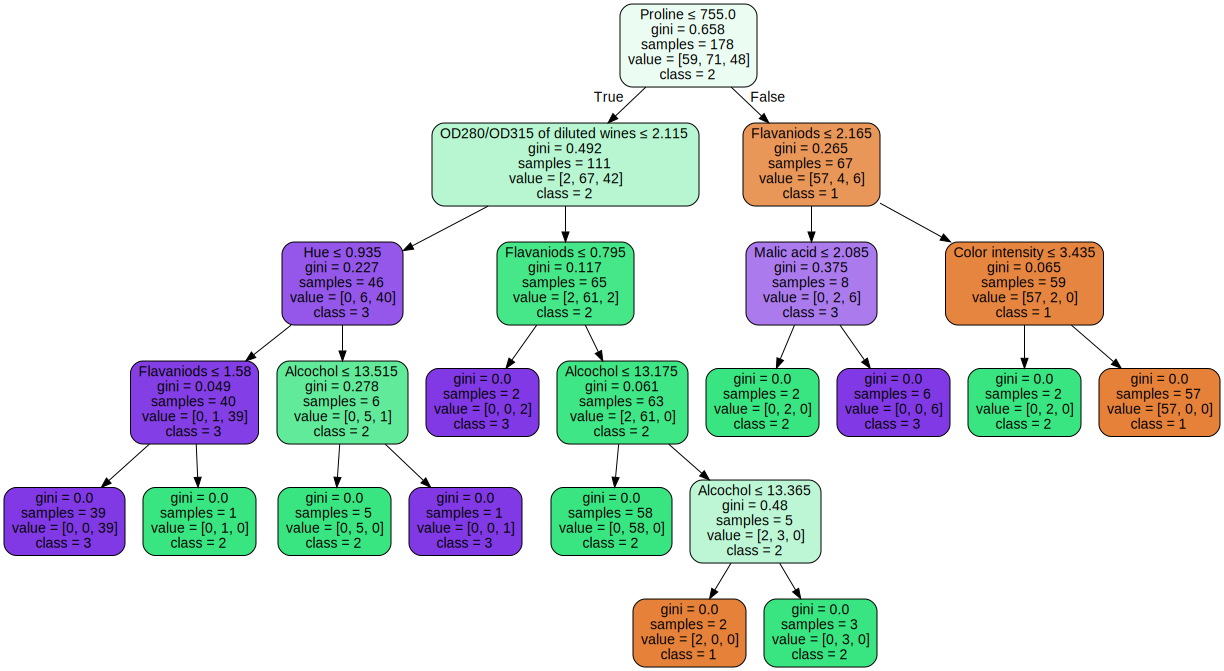

In [7]:
# Wizulizacja pełnego drzewa decyzyjnego
import graphviz
features = list(wines.columns[1:])
classes = ["1","2","3"]
dot_data = tree.export_graphviz(dtree, out_file=None, feature_names=features,  class_names=classes,  filled=True, rounded=True,  special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

In [8]:
# Zbiór treningowy
X = wines.drop("Class",axis=1)
y = wines["Class"]

In [9]:
# Wyznaczanie wartości parametru ccp_alpha
dtree = DecisionTreeClassifier()
path = dtree.cost_complexity_pruning_path(X, y)
ccp_alphas = path['ccp_alphas']

In [10]:
# Dla każdej wartości ccp_alpha wykonujemy kroswalidację drzewa
trees_scores = []
for ccp_alpha in ccp_alphas:
    dtree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    dtree.fit(X, y)
    predictions = cross_val_predict(dtree, X, y, cv=10)
    trees_scores.append(accuracy_score(y, predictions))

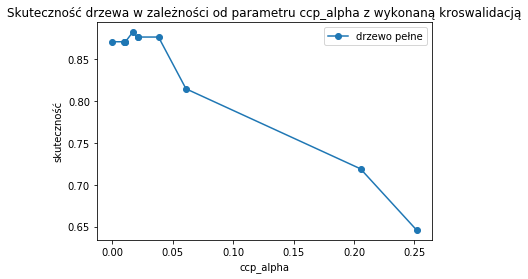

In [12]:
# Wykres skuteczności od wartości ccp_alpha
fig, ax = plt.subplots()
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("skuteczność")
ax.set_title("Skuteczność drzewa w zależności od parametru ccp_alpha z wykonaną kroswalidacją")
ax.plot(ccp_alphas, trees_scores, marker='o', label="drzewo pełne")
ax.legend()
plt.show()

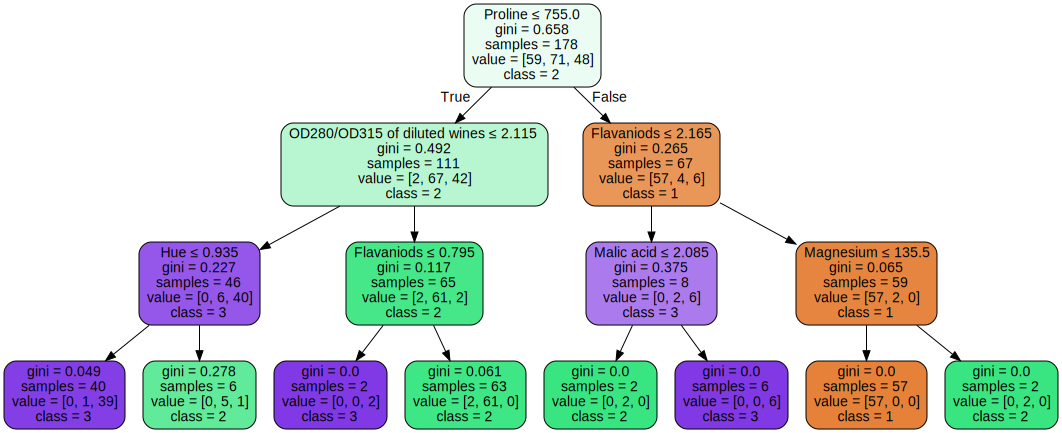

In [13]:
# Rysowanie optymalnego drzewa
dtree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alphas[3])
dtree.fit(X, y)
dot_data = tree.export_graphviz(dtree, out_file=None, feature_names=features,  class_names=classes,  filled=True, rounded=True,  special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

In [14]:
# Porównanie najlepszej skuteczność dla drzewa pełnego i optymalnego

# drzewo pełne
print("Skuteczność na pełnym drzewie: ",best_acc_full)

# drzewo optymalne
best_alpha = ccp_alphas[np.argmax(trees_scores)]
best_acc = np.max(trees_scores)
print("Skuteczność na optymalnym drzewie: ",best_acc)

Skuteczność na pełnym drzewie:  0.8764044943820225
Skuteczność na optymalnym drzewie:  0.8820224719101124


#### Widzimy, że skuteczność na optymalnym drzewie (przyciętym) wzrosła w stosunku do pełnego drzewa (nieprzyciętego)

In [15]:
y = wines["Class"]
trees_scores = []
opt_trees_scores = []
leaves_full = []
leaves_opt = []

# tworzenie drzewa pełnego i optymalnego dla różnych ilości zmiennych
for i in range(3,15):
    X = wines.iloc[:,1:i]
    
    # pełne drzewo
    dtree = DecisionTreeClassifier()
    dtree.fit(X,y)
    predictions = cross_val_predict(dtree, X, y, cv=10)
    leaves_full.append(dtree.get_n_leaves())
    trees_scores.append(accuracy_score(y, predictions))
    

    # optymalne drzewo
    path = dtree.cost_complexity_pruning_path(X, y)
    ccp_alphas = path['ccp_alphas']
    
    # szukanie najlepszego optymalnego drzewa dla wszystkich mozliwych ccp_alpha
    best_opt_tree_scores = []
    for ccp_alpha in ccp_alphas:
        dtree = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
        dtree.fit(X, y)
        predictions = cross_val_predict(dtree, X, y, cv=10)
        best_opt_tree_scores.append(accuracy_score(y, predictions))
    best_alpha = ccp_alphas[np.argmax(best_opt_tree_scores)]
    best_opt_acc = np.max(trees_scores)
    opt_trees_scores.append(best_opt_acc)
    
    dtree = DecisionTreeClassifier(ccp_alpha=best_alpha)
    dtree.fit(X,y)
    leaves_opt.append(dtree.get_n_leaves())

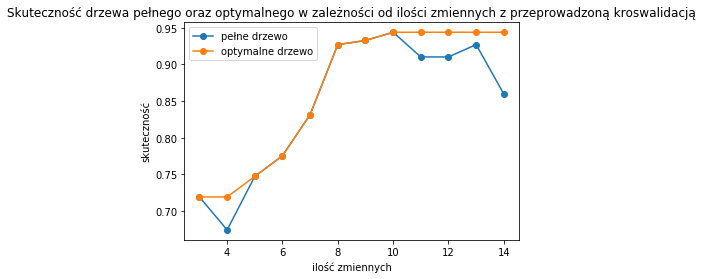

In [16]:
# Wykres skuteczności drzewa pełnego i optymlanego w zależności od liczby zmiennych
fig, ax = plt.subplots()
ax.set_xlabel("ilość zmiennych")
ax.set_ylabel("skuteczność")
ax.set_title("Skuteczność drzewa pełnego oraz optymalnego w zależności od ilości zmiennych z przeprowadzoną kroswalidacją")
ax.plot(list(range(3,15)), trees_scores, marker='o', label="pełne drzewo")
ax.plot(list(range(3,15)), opt_trees_scores, marker='o', label="optymalne drzewo")
ax.legend()
plt.show()

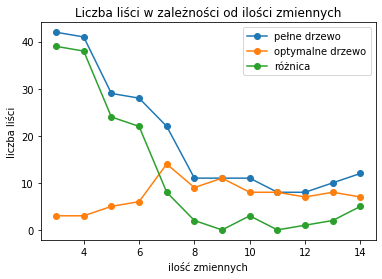

In [17]:
# Wykres liczby liści (rozmiaru) drzewa pełnego i optymlanego w zależności od liczby zmiennych
delta_leaves = []

zip_object = zip(leaves_full, leaves_opt)
for list1, list2 in zip_object:
    delta_leaves.append(list1-list2)

fig, ax = plt.subplots()
ax.set_xlabel("ilość zmiennych")
ax.set_ylabel("liczba liści")
ax.set_title("Liczba liści w zależności od ilości zmiennych")
ax.plot(list(range(3,15)), leaves_full, marker='o', label="pełne drzewo")
ax.plot(list(range(3,15)), leaves_opt, marker='o', label="optymalne drzewo")
ax.plot(list(range(3,15)), delta_leaves, marker='o', label="różnica")
ax.legend()
plt.show()